# Imports and General Settings

In [1]:

import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import random

from cleverhans.loss import SNNLCrossEntropy

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

tf.enable_eager_execution()

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())


/device:GPU:0


# Utility Functions

In [2]:

# Xavier : tf_contrib.layers.xavier_initializer()
# He : tf_contrib.layers.variance_scaling_initializer()
# Normal : tf.random_normal_initializer(mean=0.0, stddev=0.02)
# l2_decay : tf_contrib.layers.l2_regularizer(0.0001)

weight_init = tf_contrib.layers.variance_scaling_initializer()
weight_regularizer = tf_contrib.layers.l2_regularizer(0.0001)


##################################################################################
# Layer
##################################################################################

def conv(x, channels, kernel=4, stride=2, padding='SAME', use_bias=True, scope='conv_0'):
    with tf.variable_scope(scope):
        x = tf.layers.conv2d(inputs=x, filters=channels,
                             kernel_size=kernel, kernel_initializer=weight_init,
                             kernel_regularizer=weight_regularizer,
                             strides=stride, use_bias=use_bias, padding=padding)

        return x

def fully_connected(x, units, use_bias=True, scope='fully_0'):
    with tf.variable_scope(scope):
        x = flatten(x)
        x = tf.layers.dense(x, units=units, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer, use_bias=use_bias)

        return x
    
def dense(x, units, use_bias=True, scope='dense_0'):
    with tf.variable_scope(scope):
        x = tf.layers.dense(x, units=units, kernel_initializer=weight_init, kernel_regularizer=weight_regularizer, use_bias=use_bias)
    
        return x

def resblock(x_init, channels, kernel=3, is_training=True, use_bias=True, downsample=False, scope='resblock') :
    with tf.variable_scope(scope) :

        x = batch_norm(x_init, is_training, scope='batch_norm_0')
        x = relu(x)

        if downsample :
            x = conv(x, channels, kernel=kernel, stride=2, use_bias=use_bias, scope='conv_0')
            x_init = conv(x_init, channels, kernel=1, stride=2, use_bias=use_bias, scope='conv_init')

        else :
            x = conv(x, channels, kernel=kernel, stride=1, use_bias=use_bias, scope='conv_0')

        x = batch_norm(x, is_training, scope='batch_norm_1')
        x = relu(x)
        x = conv(x, channels, kernel=kernel, stride=1, use_bias=use_bias, scope='conv_1')

        return x + x_init

def bottle_resblock(x_init, channels, is_training=True, use_bias=True, downsample=False, scope='bottle_resblock') :
    with tf.variable_scope(scope) :
        x = batch_norm(x_init, is_training, scope='batch_norm_1x1_front')
        shortcut = relu(x)

        x = conv(shortcut, channels, kernel=1, stride=1, use_bias=use_bias, scope='conv_1x1_front')
        x = batch_norm(x, is_training, scope='batch_norm_3x3')
        x = relu(x)

        if downsample :
            x = conv(x, channels, kernel=3, stride=2, use_bias=use_bias, scope='conv_0')
            shortcut = conv(shortcut, channels*4, kernel=1, stride=2, use_bias=use_bias, scope='conv_init')

        else :
            x = conv(x, channels, kernel=3, stride=1, use_bias=use_bias, scope='conv_0')
            shortcut = conv(shortcut, channels * 4, kernel=1, stride=1, use_bias=use_bias, scope='conv_init')

        x = batch_norm(x, is_training, scope='batch_norm_1x1_back')
        x = relu(x)
        x = conv(x, channels*4, kernel=1, stride=1, use_bias=use_bias, scope='conv_1x1_back')

        return x + shortcut


##################################################################################
# Sampling
##################################################################################

def flatten(x) :
    return tf.layers.flatten(x)

def global_avg_pooling(x):
    gap = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    return gap

def avg_pooling(x) :
    return tf.layers.average_pooling2d(x, pool_size=2, strides=2, padding='SAME')

def max_pooling(x) :
    return tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding='SAME')


##################################################################################
# Activation function
##################################################################################

def relu(x):
    return tf.nn.relu(x)


##################################################################################
# Normalization function
##################################################################################

def batch_norm(x, is_training=True, scope='batch_norm'):
    return tf_contrib.layers.batch_norm(x,
                                        decay=0.9, epsilon=1e-05,
                                        center=True, scale=True, updates_collections=None,
                                        is_training=is_training, scope=scope)

##################################################################################
# Loss function
##################################################################################

def classification_loss(logit, label) :
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label, logits=logit))
    prediction = tf.equal(tf.argmax(logit, -1), tf.argmax(label, -1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

    return loss, accuracy


# Loading Data

## Data Augmentation Functions

In [3]:

def rotate(image):
    
    return tf.image.rot90(image, tf.random_uniform(shape=[], minval=0, maxval=4, 
                                               dtype=tf.int32))

def flip(image):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image

def crop(image, range_start=0.8, range_end=1.0):
    
    image = tf.image.central_crop(image, central_fraction=random.uniform(range_start, range_end))
    image = tf.image.resize_images(image,tf.constant([512, 512]))
    return image

def translate(image,  x_max=75, y_max=75):
    
    return tf.contrib.image.translate(image, translations=[random.uniform(-1 * x_max, x_max), 
                                                           random.uniform(-1 * y_max, y_max)])

def augment_image(image):
                       
        
    print(image)
    
    image = rotate(image)
    image = flip(image)
    
    image = translate(image)
    image = crop(image)
    
    return image


## Importing Data

In [4]:
# load an array of image paths
def load_image_paths(path):
    
    data_root = pathlib.Path(path)
    
    # create a list of every file and its label index
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    
    return all_image_paths

# randomly shuffle train and test values and split based on parameters
def split(image_paths, split=[0.6,0.2,0.2], seed=777):
    random.Random(seed).shuffle(image_paths)
    
    boundary1 = int(len(image_paths) * split[0])
    boundary2 = int(len(image_paths) * (split[0]+split[1]))
    
    train = image_paths[:boundary1]
    evaluate = image_paths[boundary1: boundary2]
    test = image_paths[boundary2:]
    
    return train, evaluate, test

# preprocessing functions
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=[512,512])
    image = tf.div(
       tf.subtract(
          image, 
          tf.reduce_min(image)
       ), 
       tf.subtract(
          tf.reduce_max(image), 
          tf.reduce_min(image)
       )
    )
    
    return image

def load_and_preprocess_image(path, training=True):
    image = tf.read_file(path)
    image = preprocess_image(image)
    
    if (training):
        image = augment_image(image[:,:,None])
    
    return image

def load(path, image_paths, training=True, batch_size=64):
    with tf.device("/CPU:0"):
        # data root
        data_root = pathlib.Path(path)

        # return label names
        label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

        # assign index to label
        label_to_index = dict((name, index) for index,name in enumerate(label_names))

        # array of all labels corresponding to image_paths
        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in image_paths]

        # make path dataset
        path_ds = tf.data.Dataset.from_tensor_slices(image_paths)

        # get image tensors by mapping function over the path dataset
        image_ds = path_ds.map(lambda path : load_and_preprocess_image(path, training=training))

        # create label dataset
        label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

        # zip together image and label dataset into dataset of tuples for
        # estimator input
        image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

        # Setting a shuffle buffer size as large as the dataset ensures that the data is
        # completely shuffled.
        
        
        
        if batch_size == None:
            image_label_ds = image_label_ds.batch(len(image_paths))
        else:
            image_label_ds = image_label_ds.batch(batch_size)
        
        if (training):
            print("shuffling and repeating b/c training flag set")

            image_label_ds = image_label_ds.repeat()
            image_label_ds = image_label_ds.shuffle(buffer_size = len(image_paths))
        else:
            image_label_ds = image_label_ds.repeat(count=1)
        
        # `prefetch` lets the dataset fetch batches, in the background while the model is training.
        image_label_ds = image_label_ds.prefetch(6)
       
        
        return image_label_ds

# ResNet-10

## Architecture

In [5]:
num_classes = 3

# ResNet-10 architecture
def resnet10_network(x, conv_kernel=7, resblock_kernel=3, num_channels=4, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('Resnet-10', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        x = conv(x, num_channels, kernel=conv_kernel, stride=1, padding='SAME')

        x = resblock(x, channels=num_channels, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock0_id1')
            
        x = resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, downsample=True, scope='resblock_conv1')

        x = resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock1_id1')
        
        x = resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, downsample=True, scope='resblock_conv2')

        x = resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock2_id1')
        
        x = batch_norm(x, is_training, scope='batch_norm')
        x = relu(x)
        
        print(x)

        x = flatten(x)
        
        return x
    
def resnet10_model_fn(features, labels, mode, conv_kernel=7, resblock_kernel=3, num_channels=4, snnl_weight=0.05):
    with tf.device(gpu):
        
        features_train = resnet10_network(features, conv_kernel=conv_kernel, 
                                        resblock_kernel=resblock_kernel, 
                                        num_channels=num_channels, 
                                        n_classes=num_classes, 
                                        reuse=False, 
                                        is_training=True)
        
        logits_train = dense(features_train, num_classes, scope="dense_train")
        
        features_test = resnet10_network(features, 
                                       conv_kernel=conv_kernel, 
                                       resblock_kernel=resblock_kernel, 
                                       num_channels=num_channels, 
                                       n_classes=num_classes, 
                                       reuse=True, 
                                       is_training=False)
        
        logits_test = dense(features_test, num_classes, scope="dense_test")
        
        # find highest val (prediction)
        pred_classes = tf.arg_max(logits_test, dimension=1)

        # if in prediction mode
        if mode == tf.estimator.ModeKeys.PREDICT:
            
            return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)
        
        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
        
        loss_op = snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(features_train, labels, 20.0, True) + (1.0 - snnl_weight) * loss_op
    
        # implement weighted sum
        
        print(loss_op)
        
        tf.summary.scalar("loss", loss_op)
        
        # Evaluate model accuracy
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
        tf.summary.scalar("training_accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
            
            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op},
            ) 

            return estim_specs
        
        elif mode == tf.estimator.ModeKeys.EVAL:
   
            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                eval_metric_ops={'accuracy': acc_op},
            ) 

            return estim_specs
       
        else:
            print("Something went wrong.")


## Experimentation

In [ ]:

tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.0001

random_seed = 777

num_steps = 20000

resnet10_checkpoint_path_base = "/data/jma/model/resnet10/"

kernel_sizes = [7]
filter_sizes = [8]
snnl_weights = [0.05, 0.1, 0.2, 0.3, 0.5]

data_root = "./data_3classes/"

image_paths = load_image_paths(data_root)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)

train_input_fn = lambda : load(data_root, train_paths, training=True, batch_size=b_size)
eval_input_fn = lambda : load(data_root, eval_paths, training=False, batch_size=b_size)
test_input_fn = lambda : load(data_root, test_paths, training=False, batch_size=b_size)

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"
            print(model_path)

            config = tf.estimator.RunConfig(
                log_step_count_steps= 20,
                save_summary_steps= 50,
                save_checkpoints_secs= 600,
                model_dir=model_path,
                tf_random_seed=random_seed,
                session_config=session_config)

            model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight)

            model = tf.estimator.Estimator(model_fn=model_fn, config=config)

            train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
            eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn)

            tf.estimator.train_and_evaluate(model, train_spec, eval_spec)


        
        

/data/jma/model/resnet10/kernel7_filter8_snnl0.05/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/resnet10/kernel7_filter8_snnl0.05/', '_tf_random_seed': 777, '_save_summary_steps': 50, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f51aa8c7a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate wi

INFO:tensorflow:Saving dict for global step 1021: accuracy = 0.54037267, global_step = 1021, loss = 2.1713724
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1021: /data/jma/model/resnet10/kernel7_filter8_snnl0.05/model.ckpt-1021
INFO:tensorflow:global_step/sec: 1.71058
INFO:tensorflow:loss = 0.43314114, step = 1020 (11.691 sec)
INFO:tensorflow:global_step/sec: 3.45877
INFO:tensorflow:loss = 1.0079842, step = 1040 (5.786 sec)
INFO:tensorflow:global_step/sec: 2.4708
INFO:tensorflow:loss = 0.064984456, step = 1060 (8.093 sec)
INFO:tensorflow:global_step/sec: 2.48822
INFO:tensorflow:loss = 0.91664904, step = 1080 (8.037 sec)
INFO:tensorflow:global_step/sec: 2.54339
INFO:tensorflow:loss = 0.11758847, step = 1100 (7.865 sec)
INFO:tensorflow:global_step/sec: 2.54472
INFO:tensorflow:loss = 1.0982935, step = 1120 (7.859 sec)
INFO:tensorflow:global_step/sec: 2.51854
INFO:tensorflow:loss = 0.15912634, step = 1140 (7.941 sec)
INFO:tensorflow:global_step/sec: 2.41575
INFO:tensorfl

Tensor("add_4:0", shape=(), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-19-23:17:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10/kernel7_filter8_snnl0.05/model.ckpt-2552
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-19-23:17:34
INFO:tensorflow:Saving dict for global step 2552: accuracy = 0.50931674, global_step = 2552, loss = 1.5023624
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2552: /data/jma/model/resnet10/kernel7_filter8_snnl0.05/model.ckpt-2552
INFO:tensorflow:global_step/sec: 1.91364
INFO:tensorflow:loss = 0.3297401, step = 2560 (10.451 sec)
INFO:tensorflow:global_step/sec: 2.93507
INFO:tensorflow:loss = 0.15921772, step = 2580 (6.816 sec)
INFO:tensorflow:global_step/sec: 2.43958
INFO:tensorflow:loss = 0.23374799, step = 2600 (8.199 sec)
INF

INFO:tensorflow:loss = 0.15913288, step = 4060 (7.420 sec)
INFO:tensorflow:global_step/sec: 2.59814
INFO:tensorflow:loss = 0.22585474, step = 4080 (7.698 sec)
INFO:tensorflow:Saving checkpoints for 4087 into /data/jma/model/resnet10/kernel7_filter8_snnl0.05/model.ckpt.
INFO:tensorflow:Calling model_fn.
Tensor("Resnet-10/Relu:0", shape=(?, 128, 128, 32), dtype=float32, device=/device:GPU:0)
Tensor("Resnet-10_1/Relu:0", shape=(?, 128, 128, 32), dtype=float32, device=/device:GPU:0)
Tensor("add_4:0", shape=(), dtype=float32, device=/device:GPU:0)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-19-23:27:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10/kernel7_filter8_snnl0.05/model.ckpt-4087
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-19-23:27:34
INFO:tensorflow:Saving dict for global step 4087: accuracy = 0.490

INFO:tensorflow:loss = 0.37368354, step = 5500 (7.897 sec)
INFO:tensorflow:global_step/sec: 2.67895
INFO:tensorflow:loss = 0.20627992, step = 5520 (7.465 sec)
INFO:tensorflow:global_step/sec: 2.57748
INFO:tensorflow:loss = 0.49310067, step = 5540 (7.760 sec)
INFO:tensorflow:global_step/sec: 2.4625
INFO:tensorflow:loss = 0.13982947, step = 5560 (8.121 sec)
INFO:tensorflow:global_step/sec: 2.62321
INFO:tensorflow:loss = 0.29159778, step = 5580 (7.624 sec)
INFO:tensorflow:global_step/sec: 2.61591
INFO:tensorflow:loss = 0.2141563, step = 5600 (7.647 sec)
INFO:tensorflow:global_step/sec: 2.62425
INFO:tensorflow:loss = 0.060587037, step = 5620 (7.621 sec)
INFO:tensorflow:Saving checkpoints for 5628 into /data/jma/model/resnet10/kernel7_filter8_snnl0.05/model.ckpt.
INFO:tensorflow:Calling model_fn.
Tensor("Resnet-10/Relu:0", shape=(?, 128, 128, 32), dtype=float32, device=/device:GPU:0)
Tensor("Resnet-10_1/Relu:0", shape=(?, 128, 128, 32), dtype=float32, device=/device:GPU:0)
Tensor("add_4:0",

INFO:tensorflow:loss = 0.06661928, step = 6940 (7.925 sec)
INFO:tensorflow:global_step/sec: 2.62805
INFO:tensorflow:loss = 0.23302893, step = 6960 (7.609 sec)
INFO:tensorflow:global_step/sec: 2.5688
INFO:tensorflow:loss = 0.07198079, step = 6980 (7.786 sec)
INFO:tensorflow:global_step/sec: 2.5389
INFO:tensorflow:loss = 0.16063711, step = 7000 (7.880 sec)
INFO:tensorflow:global_step/sec: 2.52928
INFO:tensorflow:loss = 0.112604834, step = 7020 (7.905 sec)
INFO:tensorflow:global_step/sec: 2.65877
INFO:tensorflow:loss = 0.21528526, step = 7040 (7.523 sec)
INFO:tensorflow:global_step/sec: 2.54376
INFO:tensorflow:loss = 0.4606578, step = 7060 (7.862 sec)
INFO:tensorflow:global_step/sec: 2.57271
INFO:tensorflow:loss = 0.09853179, step = 7080 (7.774 sec)
INFO:tensorflow:global_step/sec: 2.59945
INFO:tensorflow:loss = 0.06500037, step = 7100 (7.695 sec)
INFO:tensorflow:global_step/sec: 2.71285
INFO:tensorflow:loss = 0.15959142, step = 7120 (7.372 sec)
INFO:tensorflow:global_step/sec: 2.54207
IN

INFO:tensorflow:loss = 0.052298207, step = 8380 (7.542 sec)
INFO:tensorflow:global_step/sec: 2.55962
INFO:tensorflow:loss = 0.3091726, step = 8400 (7.814 sec)
INFO:tensorflow:global_step/sec: 2.61371
INFO:tensorflow:loss = 0.16091931, step = 8420 (7.651 sec)
INFO:tensorflow:global_step/sec: 2.52034
INFO:tensorflow:loss = 0.13851744, step = 8440 (7.935 sec)
INFO:tensorflow:global_step/sec: 2.58984
INFO:tensorflow:loss = 0.31673142, step = 8460 (7.723 sec)
INFO:tensorflow:global_step/sec: 2.64778
INFO:tensorflow:loss = 0.061687417, step = 8480 (7.553 sec)
INFO:tensorflow:global_step/sec: 2.55615
INFO:tensorflow:loss = 0.17757958, step = 8500 (7.825 sec)
INFO:tensorflow:global_step/sec: 2.59879
INFO:tensorflow:loss = 0.22050011, step = 8520 (7.695 sec)
INFO:tensorflow:global_step/sec: 2.61891
INFO:tensorflow:loss = 0.26997888, step = 8540 (7.637 sec)
INFO:tensorflow:global_step/sec: 2.60781
INFO:tensorflow:loss = 0.059737314, step = 8560 (7.670 sec)
INFO:tensorflow:global_step/sec: 2.5604

INFO:tensorflow:loss = 0.12157252, step = 9820 (7.614 sec)
INFO:tensorflow:global_step/sec: 2.62113
INFO:tensorflow:loss = 0.060191803, step = 9840 (7.630 sec)
INFO:tensorflow:global_step/sec: 2.55574
INFO:tensorflow:loss = 0.103012756, step = 9860 (7.826 sec)
INFO:tensorflow:global_step/sec: 2.551
INFO:tensorflow:loss = 0.06225678, step = 9880 (7.841 sec)
INFO:tensorflow:global_step/sec: 2.51747
INFO:tensorflow:loss = 0.07638635, step = 9900 (7.946 sec)
INFO:tensorflow:global_step/sec: 2.65021
INFO:tensorflow:loss = 0.049210936, step = 9920 (7.545 sec)
INFO:tensorflow:global_step/sec: 2.57199
INFO:tensorflow:loss = 0.39410135, step = 9940 (7.775 sec)
INFO:tensorflow:global_step/sec: 2.54515
INFO:tensorflow:loss = 0.123276666, step = 9960 (7.858 sec)
INFO:tensorflow:global_step/sec: 2.60454
INFO:tensorflow:loss = 0.20215268, step = 9980 (7.679 sec)
INFO:tensorflow:global_step/sec: 2.63788
INFO:tensorflow:loss = 0.21670642, step = 10000 (7.582 sec)
INFO:tensorflow:global_step/sec: 2.586

INFO:tensorflow:loss = 0.1117474, step = 11240 (7.864 sec)
INFO:tensorflow:global_step/sec: 2.56038
INFO:tensorflow:loss = 0.13768837, step = 11260 (7.813 sec)
INFO:tensorflow:global_step/sec: 2.61537
INFO:tensorflow:loss = 0.06098389, step = 11280 (7.646 sec)
INFO:tensorflow:global_step/sec: 2.55263
INFO:tensorflow:loss = 0.055747293, step = 11300 (7.835 sec)
INFO:tensorflow:global_step/sec: 2.59885
INFO:tensorflow:loss = 0.19880317, step = 11320 (7.695 sec)
INFO:tensorflow:global_step/sec: 2.53186
INFO:tensorflow:loss = 0.064510085, step = 11340 (7.899 sec)
INFO:tensorflow:global_step/sec: 2.57254
INFO:tensorflow:loss = 0.053144053, step = 11360 (7.776 sec)
INFO:tensorflow:global_step/sec: 2.5789
INFO:tensorflow:loss = 0.084412456, step = 11380 (7.754 sec)
INFO:tensorflow:global_step/sec: 2.56098
INFO:tensorflow:loss = 0.103240065, step = 11400 (7.810 sec)
INFO:tensorflow:global_step/sec: 2.5511
INFO:tensorflow:loss = 0.22427489, step = 11420 (7.839 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.058217533, step = 12660 (7.680 sec)
INFO:tensorflow:global_step/sec: 2.48627
INFO:tensorflow:loss = 0.12431672, step = 12680 (8.046 sec)
INFO:tensorflow:global_step/sec: 2.5758
INFO:tensorflow:loss = 0.1422503, step = 12700 (7.764 sec)
INFO:tensorflow:global_step/sec: 2.58467
INFO:tensorflow:loss = 0.05529146, step = 12720 (7.738 sec)
INFO:tensorflow:global_step/sec: 2.57674
INFO:tensorflow:loss = 0.10744354, step = 12740 (7.762 sec)
INFO:tensorflow:global_step/sec: 2.57907
INFO:tensorflow:loss = 0.20280713, step = 12760 (7.754 sec)
INFO:tensorflow:global_step/sec: 2.57164
INFO:tensorflow:loss = 0.16558902, step = 12780 (7.777 sec)
INFO:tensorflow:global_step/sec: 2.56656
INFO:tensorflow:loss = 0.15846355, step = 12800 (7.796 sec)
INFO:tensorflow:global_step/sec: 2.59296
INFO:tensorflow:loss = 0.06488247, step = 12820 (7.710 sec)
INFO:tensorflow:global_step/sec: 2.55436
INFO:tensorflow:loss = 0.052236028, step = 12840 (7.830 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:loss = 0.057387374, step = 14080 (7.804 sec)
INFO:tensorflow:global_step/sec: 2.53312
INFO:tensorflow:loss = 0.061426632, step = 14100 (7.896 sec)
INFO:tensorflow:global_step/sec: 2.58493
INFO:tensorflow:loss = 0.16162056, step = 14120 (7.737 sec)
INFO:tensorflow:global_step/sec: 2.56859
INFO:tensorflow:loss = 0.25495705, step = 14140 (7.786 sec)
INFO:tensorflow:global_step/sec: 2.63747
INFO:tensorflow:loss = 0.08759844, step = 14160 (7.583 sec)
INFO:tensorflow:global_step/sec: 2.47827
INFO:tensorflow:loss = 0.2624787, step = 14180 (8.072 sec)
INFO:tensorflow:global_step/sec: 2.55571
INFO:tensorflow:loss = 0.06627243, step = 14200 (7.825 sec)
INFO:tensorflow:global_step/sec: 2.60274
INFO:tensorflow:loss = 0.13338502, step = 14220 (7.683 sec)
INFO:tensorflow:global_step/sec: 2.71117
INFO:tensorflow:loss = 0.1606824, step = 14240 (7.377 sec)
INFO:tensorflow:global_step/sec: 2.51899
INFO:tensorflow:loss = 0.099140145, step = 14260 (7.940 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:loss = 0.06994452, step = 15500 (7.785 sec)
INFO:tensorflow:global_step/sec: 2.56992
INFO:tensorflow:loss = 0.06223607, step = 15520 (7.781 sec)
INFO:tensorflow:global_step/sec: 2.57702
INFO:tensorflow:loss = 0.13374457, step = 15540 (7.761 sec)
INFO:tensorflow:global_step/sec: 2.53831
INFO:tensorflow:loss = 0.15992709, step = 15560 (7.881 sec)
INFO:tensorflow:global_step/sec: 2.56971
INFO:tensorflow:loss = 0.12277982, step = 15580 (7.782 sec)
INFO:tensorflow:global_step/sec: 2.6617
INFO:tensorflow:loss = 0.06845837, step = 15600 (7.515 sec)
INFO:tensorflow:global_step/sec: 2.57862
INFO:tensorflow:loss = 0.09821913, step = 15620 (7.754 sec)
INFO:tensorflow:global_step/sec: 2.56346
INFO:tensorflow:loss = 0.053656433, step = 15640 (7.802 sec)
INFO:tensorflow:global_step/sec: 2.61359
INFO:tensorflow:loss = 0.058034062, step = 15660 (7.652 sec)
INFO:tensorflow:global_step/sec: 2.66437
INFO:tensorflow:loss = 0.2666462, step = 15680 (7.507 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:loss = 0.05228368, step = 16920 (7.883 sec)
INFO:tensorflow:global_step/sec: 2.65271
INFO:tensorflow:loss = 0.092952, step = 16940 (7.539 sec)
INFO:tensorflow:global_step/sec: 2.62268
INFO:tensorflow:loss = 0.05688848, step = 16960 (7.626 sec)
INFO:tensorflow:global_step/sec: 2.58125
INFO:tensorflow:loss = 0.054689713, step = 16980 (7.748 sec)
INFO:tensorflow:global_step/sec: 2.49902
INFO:tensorflow:loss = 0.07755947, step = 17000 (8.004 sec)
INFO:tensorflow:global_step/sec: 2.59062
INFO:tensorflow:loss = 0.4000963, step = 17020 (7.721 sec)
INFO:tensorflow:global_step/sec: 2.63105
INFO:tensorflow:loss = 0.052768562, step = 17040 (7.600 sec)
INFO:tensorflow:global_step/sec: 2.55128
INFO:tensorflow:loss = 0.16495106, step = 17060 (7.839 sec)
INFO:tensorflow:global_step/sec: 2.58005
INFO:tensorflow:loss = 0.16203608, step = 17080 (7.752 sec)
INFO:tensorflow:global_step/sec: 2.59356
INFO:tensorflow:loss = 0.32967815, step = 17100 (7.712 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:loss = 0.09945193, step = 18340 (7.780 sec)
INFO:tensorflow:global_step/sec: 2.60791
INFO:tensorflow:loss = 0.086221725, step = 18360 (7.669 sec)
INFO:tensorflow:global_step/sec: 2.59388
INFO:tensorflow:loss = 0.34339666, step = 18380 (7.711 sec)


In [ ]:
labels = path_to_label(train_paths, "./data_3classes/")
        
print(labels.count(0))
print(labels.count(1))
print(labels.count(2))



## Confusion Matricies

/home_local/jma/model/resnet10/kernel10_filter16/
Tensor("IteratorGetNext:0", shape=(?, 512, 512), dtype=float32)
Tensor("Resnet-10/Relu:0", shape=(?, 128, 128, 64), dtype=float32, device=/device:GPU:2)
Tensor("IteratorGetNext:0", shape=(?, 512, 512), dtype=float32)
Tensor("Resnet-10_1/Relu:0", shape=(?, 128, 128, 64), dtype=float32, device=/device:GPU:2)


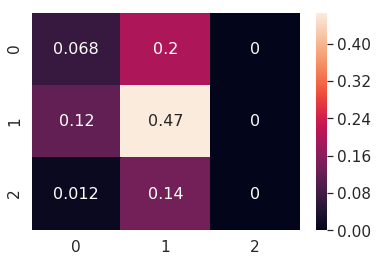

In [13]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

resnet10_checkpoint_path_base = "/home_local/jma/model/resnet10/"

kernel_sizes = [10]
filter_sizes = [16]

data_path = "./data_3classes/"

random_seed = 777

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)

def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels

train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        tf.summary.FileWriterCache.clear()
        
        model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "/"
        print(model_path)
        
        
        model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                                    conv_kernel=kernel_size, 
                                                                    num_channels=filter_size)
        model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)
        
        values = model.predict(eval_input_fn)
        
        
        original_labels = path_to_label(eval_paths, data_path)
        predicted_labels = list(values)
        
        cm = tf.confusion_matrix(original_labels, predicted_labels)
        cm = tf.to_float(cm)
    
        cm = tf.div(cm, len(original_labels))

        
        cm = cm.numpy()
        df_cm = pd.DataFrame(cm, range(3), range(3))
        #plt.figure(figsize = (10,7))
        sn.set(font_scale=1.4)#for label size
        sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
        
        plt.show()
        
        
        
        


        
        

## Expected vs. Actual

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/home_local/jma/model/resnet10/"

kernel_sizes = [3,4,5,6,7,8,9,19]
filter_sizes = [4, 10, 16]

data_path = "./data_3classes/"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)

def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels

train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=8
filter_size=10
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
        
        
        
        
        


        
        